In [46]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as si
import os
import scipy.stats as stats
cwd = os.getcwd()
plots = os.path.join(cwd,'plots')
max_anlge = 59.2 #deg

def transform_rotation(theta, gamma):
    tan_gamma = np.tan(gamma/180*np.pi)
    true_tan_alhpa = tan_gamma * np.cos(theta/180*np.pi)
    true_tan_beta = - tan_gamma * np.sin(theta/180*np.pi)
    return true_tan_alhpa, true_tan_beta

# data files for the 180 test:
data_180 = (np.loadtxt(cwd + r'\data\test_new_tia.csv', skiprows=1, delimiter=',')).T
print(data_180.shape)
time = (data_180[0] - data_180[0][0])*1e-6
alpha = data_180[9]
tan_alpha = data_180[7]
gamma = data_180[1]/16*0.9
true_tan_alpha, true_tan_beta = transform_rotation(180, gamma)
true_alpha = np.arctan(true_tan_alpha)*180/np.pi
true_beta = np.arctan(true_tan_beta)*180/np.pi

# data files for the 90 deg test:

# data files for the 45 deg test:

#data files for the 135 deg test:

(11, 20100)


In [2]:
def train_test(data, n):
    #separate test train
    data_split = np.split(data, n) # there are 100 measuerments per setting
    data_split = np.split(np.array(data_split), 2, axis=1)
    data_train = np.average(data_split[0],axis=1)
    data_test = np.average(data_split[1],axis=1)
    return data_test, data_train


def mean_diff(true, estimate):
    avg = np.average(estimate - true)
    return avg

error = alpha - true_alpha

tan_alpha_test, tan_alpha_train = train_test(tan_alpha, len(tan_alpha)/100)
tan_alpha_true_test, tan_alpha_true_train = train_test(true_tan_alpha, len(true_tan_alpha)/100)
true_alpha_test, true_alpha_train = train_test(true_alpha, len(true_alpha)/100)

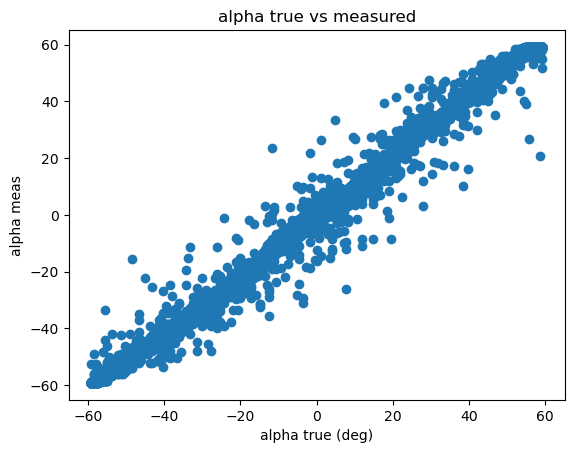

In [3]:
#Plot angle alpha against the true angle alpha the uncalibrated case.
plt.scatter(true_alpha, alpha)
plt.title("alpha true vs measured")
plt.ylabel("alpha meas")
plt.xlabel("alpha true (deg)")
plt.show()
dgs = (true_alpha < 59.2) & (true_alpha > -59.2)
errors = alpha - true_alpha
freq = np.fft.rfftfreq(len(time[dgs]), time[1]-time[0])

Error prior to calb (trainset): -0.0005970149253731349
Error after calb (trainset): -1.7675192431843288e-17
Error prior to calb (testset): 0.0014457711442786222
Error after calb (testset): 0.002042786069651744


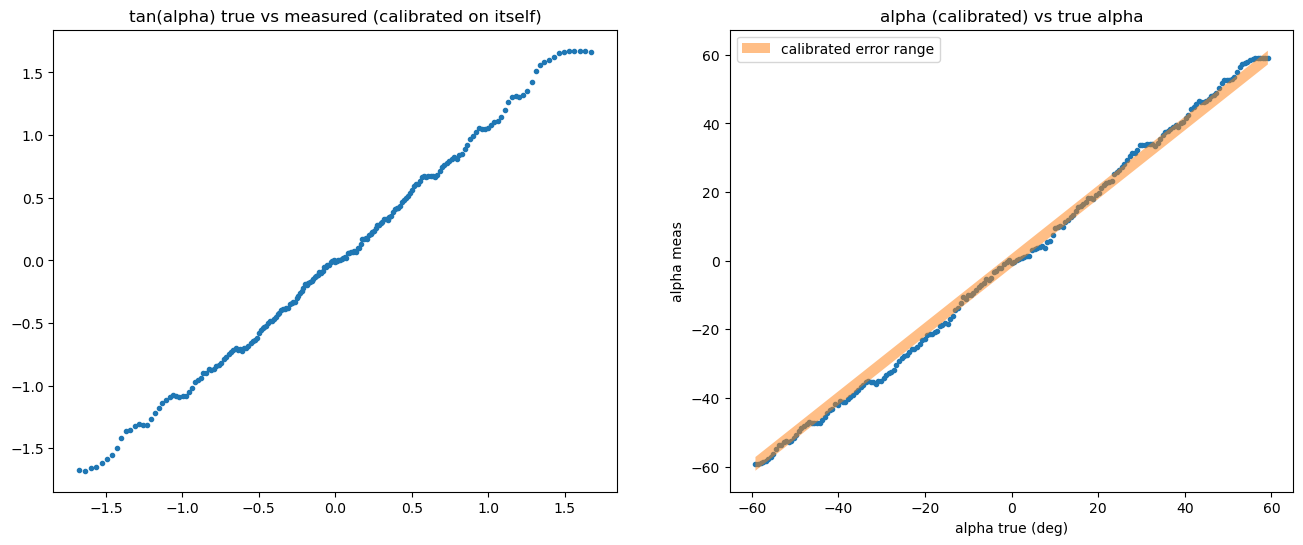

found Ca=-0.0005970149253731349


In [24]:
# the average error prior to the correction is equal to the average error.
Ca = mean_diff(tan_alpha_train, tan_alpha_true_train)
corrected_tan_alpha_train = tan_alpha_train + Ca

#error on train data after training

post_err_train = mean_diff(corrected_tan_alpha_train, tan_alpha_true_train)
# correct the test set:
corrected_tan_alpha_test = tan_alpha_test + Ca
post_err_test = mean_diff(corrected_tan_alpha_test, tan_alpha_true_test)
base_err_test = mean_diff(tan_alpha_test, tan_alpha_true_test)
print("Error prior to calb (trainset):", Ca)
print("Error after calb (trainset):", post_err_train)
print("Error prior to calb (testset):", base_err_test)
print("Error after calb (testset):", post_err_test)

# plot the calibrated training data case
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,6))
ax[0].scatter(tan_alpha_true_test, corrected_tan_alpha_test, marker=".")
ax[0].set_title("tan(alpha) true vs measured (calibrated on itself)")
ax[1].scatter(true_alpha_test, np.arctan(corrected_tan_alpha_test)*180/np.pi, marker=".")
ax[1].fill_between(true_alpha_test, true_alpha_test - 2,
                   true_alpha_test + 2, label= "calibrated error range",alpha=0.5)
ax[1].set_title("alpha (calibrated) vs true alpha")
ax[1].legend()
plt.ylabel("alpha meas")
plt.xlabel("alpha true (deg)")
plt.show()

# error after calibration
error_cab = np.arctan(corrected_tan_alpha_test)*180/np.pi - true_alpha_test
error_train = np.arctan(corrected_tan_alpha_train)*180/np.pi - true_alpha_train
print(f"found Ca={Ca}")

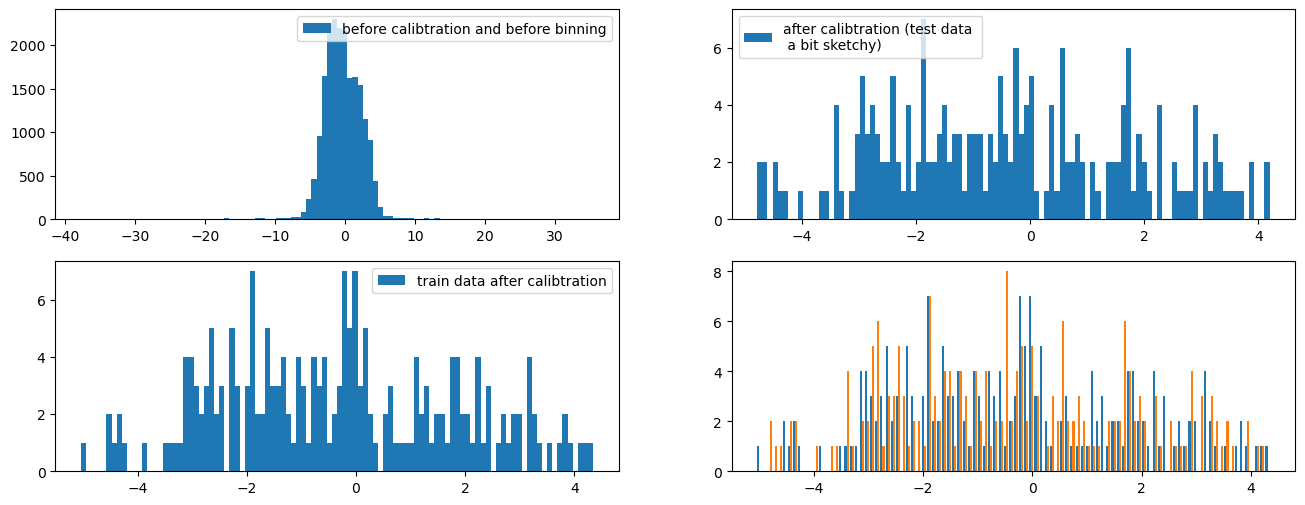

In [19]:
# Error histogram before calibration
fig, ax = plt.subplots(nrows=2,ncols=2,figsize = (16,6))
ax[0][0].hist(error,bins=100,label="before calibtration and before binning")
ax[0][0].legend()
ax[0][1].hist(error_cab,bins=100,label="after calibtration (test data \n a bit sketchy)")
ax[0][1].legend()
ax[1][0].hist(error_train, bins=100, label="train data after calibtration")
ax[1][0].legend()
ax[1][1].hist([error_train,error_cab], bins=100, label = "all calibrated data (\n also setchy)")
plt.show()

C:\MyApplcs\Anaconda3\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\MyApplcs\Anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


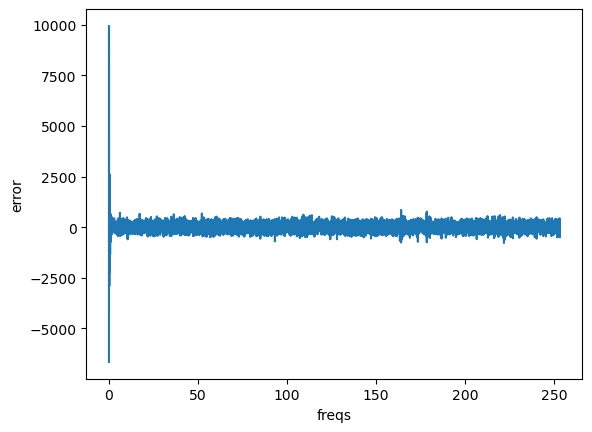

In [20]:
error_fft = np.fft.rfft(error)
#We see a misalignment with period of 200 seconds this is a freq of 0.005
plt.plot(freq, error_fft)
plt.xlabel("freqs")
plt.ylabel("error")
plt.show()

\begin{align}
    S_a = \frac{\tan{\alpha}}{\tan{\alpha_{max}}} = \frac{Q_1+ Q_4 - Q_2 - Q_3 }{Q_1+ Q_2+ Q_3 + Q_4} +\frac{C_a}{\tan{\alpha_{max}}}  \text{  (y-like)}\\
    S_b = \frac{\tan{\beta}}{\tan{\beta_{max}}} = \frac{Q_1+ Q_2 - Q_3 - Q_4}{Q_1+ Q_2+ Q_3 + Q_4} + \frac{C_b}{\tan{\beta_{max}}} \text{  (x-like)}
\end{align}
It suffices to optimize for a give true $\tan{\alpha}$ (or beta)
Then we calculate the P value based on 2 hypotheses.

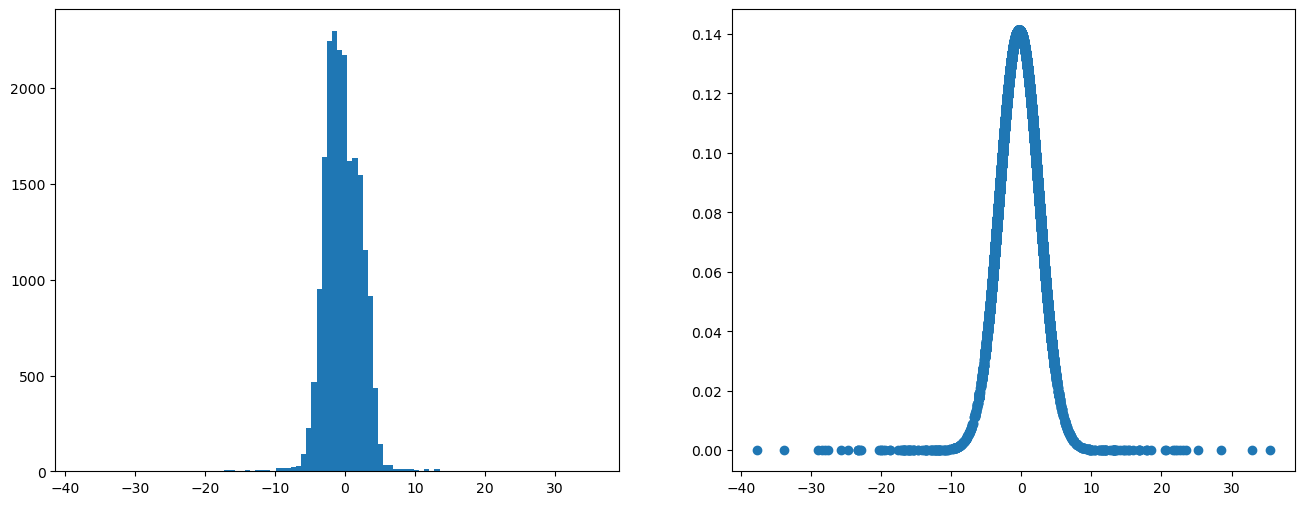

P value (distribution based) =  0.21847058408447761
P value based on samples:  0.14243781094527364
P value based on binomial:  nan


C:\Users\ebnib\AppData\Local\Temp\ipykernel_23604\1632333319.py:10: RuntimeWarning: invalid value encountered in scalar multiply
  return coff * prob**success * (1-prob)**(total-success)


In [64]:
# calculate the p value for a this scenario assume Ha uses 3.5 deg
def gaussian(avg,variance,values):
    pdf = 1/(np.sqrt(2*np.pi)*variance) * np.exp(-(values-mean)**2/(2*variance**2))
    return pdf

#binomial test needs to know how small the 2sigma interval is (3.5 uncalibrated)
def binomial(total, success, prob):
    # this function is only practical for small populations
    coff = si.special.binom(total, success)
    return coff * prob**success * (1-prob)**(total-success)

difference = alpha - true_alpha
rms = np.sqrt(np.average((difference)**2))
mean = np.average(difference)

# estimate p value with distribution
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,6))
ax[0].hist(difference,bins = 100,label="sample distribution")
ax[1].scatter(difference,gaussian(mean, rms, difference), label="distribution sim")
#ax[1].fill_between(difference, gaussian(mean, rms, difference), 0, label="P region")
plt.show()
#probability to find measuerement outside 3.5 deg
P1 = 1 - si.stats.norm.cdf(3.5, mean, rms) #probability to be outside this
P2 = si.stats.norm.cdf(-3.5, mean, rms)
P = P1 + P2
print("P value (distribution based) = ", P)
successes = len(difference[(difference < 3.5) & (difference > -3.5)])
total = len(difference)
print("P value based on samples: ", 1 - successes/total)
print("P value based on binomial: ", binomial(total, successes, 0.95))

Best factor: 0.96, RMS error: 1.41


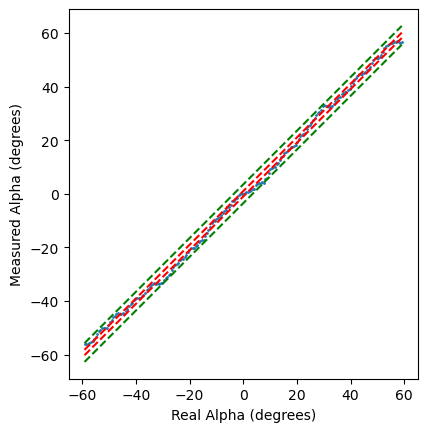

In [21]:
real_alpha = -data_180[1] * 0.9 / 16
measured_alpha = data_180[9]

# Average over N values
N = 100
real_alpha = real_alpha[::N]
measured_alpha = measured_alpha.reshape(-1, N).mean(axis=1)

rms = np.sqrt(np.mean((real_alpha - measured_alpha)**2))
measured_alpha = measured_alpha - np.mean(measured_alpha)
min_rms = rms
factor = 1.0
for i in np.arange(0.9, 1.1, 0.001):
    rms = np.sqrt(np.mean((real_alpha - measured_alpha * i)**2))
    if rms < min_rms:
        min_rms = rms
        factor = i
print(f"Best factor: {factor:.2f}, RMS error: {min_rms:.2f}")

measured_alpha *= factor
l = np.arange(-59.2, 59.2, 0.1)

plt.plot(l, l+3.5, 'g--', )
plt.plot(l, l-3.5, 'g--', )
plt.plot(l, l+1, 'r--', )
plt.plot(l, l-1, 'r--', )
plt.scatter(real_alpha, measured_alpha, s=1, label='Measured Data')
plt.xlabel('Real Alpha (degrees)')
plt.ylabel('Measured Alpha (degrees)')
plt.gca().set_aspect(1.0)
plt.show()

Best Ca: -0.01, RMS error: 2.08


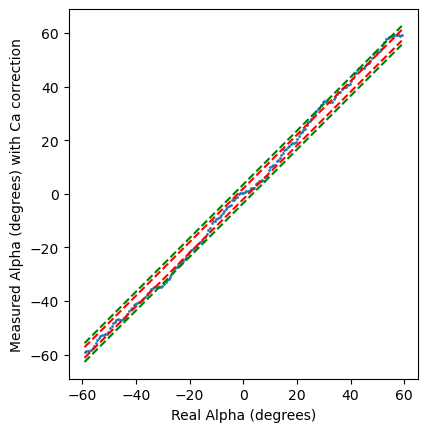

In [25]:
N=100
real_alpha = -data_180[1] * 0.9 / 16
tanAmax = np.tan(59.2/180*np.pi)

real_alpha = real_alpha[::N]

q1 = data_180[2]
q2 = data_180[3]
q3 = data_180[4]
q4 = data_180[5]
#average over every 10 samples
q1 = np.mean(q1.reshape(-1, N), axis=1)
q2 = np.mean(q2.reshape(-1, N), axis=1)
q3 = np.mean(q3.reshape(-1, N), axis=1)
q4 = np.mean(q4.reshape(-1, N), axis=1)
sum = q1 + q2 + q3 + q4
Sa = (q1 + q4 - q2 - q3) / sum

min_rms = float('inf')
Ca_min = 0.0

for Ca in np.arange(-1, 1, 0.001):
    alpha = np.arctan((Sa-Ca)*tanAmax) * 180 / np.pi
    rms = np.sqrt(np.mean((real_alpha - alpha)**2))
    if rms < min_rms:
        min_rms = rms
        Ca_min = Ca
print(f"Best Ca: {Ca_min:.2f}, RMS error: {min_rms:.2f}")
plt.plot(l, l+3.5, 'g--', )
plt.plot(l, l-3.5, 'g--', )
plt.plot(l, l+2, 'r--', )
plt.plot(l, l-2, 'r--', )
plt.scatter(real_alpha, np.arctan((Sa-Ca_min)*tanAmax) * 180 / np.pi, s=1, label='Measured Data')
plt.xlabel('Real Alpha (degrees)')
plt.ylabel('Measured Alpha (degrees) with Ca correction')
plt.gca().set_aspect(1.0)
plt.show()



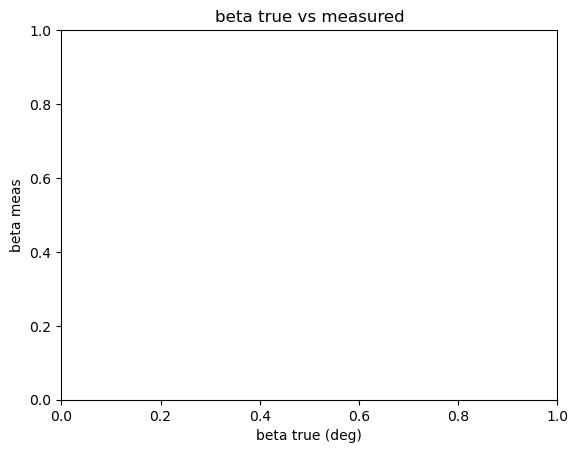

In [65]:
#Plot the angle beta against the true angle:
beta_true = np.zeros_like(data_180[1])
plt.title("beta true vs measured")
plt.ylabel("beta meas")
plt.xlabel("beta true (deg)")
plt.show()
(data_180[9][dgs] + (data_180[1]*0.9/16)[dgs]).reshape(-1,)
freq = np.fft.rfftfreq(len(time[dgs]), time[1]-time[0])

In [257]:
#average time between samples
avg_time = np.mean(np.diff(time[dgs]))
#median time between samples
median_time = np.median(np.diff(time[dgs]))
print(f"Average time between samples: {avg_time:.6f} s")
print(f"Median time between samples: {median_time:.6f} s")

Average time between samples: 0.010849 s
Median time between samples: 0.010000 s
